In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

define audiofile

In [4]:
!ls

README.md
__pycache__
audio
functions.py
letterize_your_record_2.ipynb
letterize_your_records-test_energy.ipynb
letterize_your_records.ipynb
main.py
my_functions.py
my_functions.pyc
test.jpg
test.pdf
vad.py


In [5]:
filename='./audio/cortazar.m4a'
max_sampling_rate = 22050//4

#### load audio file

In [6]:
audio, sr_temp = librosa.load(filename)

In [7]:
if sr_temp>max_sampling_rate:
    audio = librosa.resample(audio, sr_temp, max_sampling_rate)
    sr = max_sampling_rate
else:
    sr = sr_temp

In [8]:
time = np.arange(len(audio))/sr

<IPython.core.display.Javascript object>


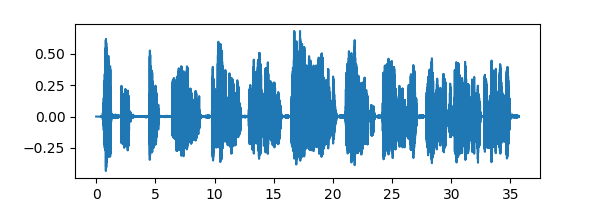

In [9]:
plt.figure(figsize = (6,2))
plt.plot(time, audio)

#### let's compute something like loudness

In [10]:
n_fft = 256
fourier = librosa.stft(audio, n_fft=n_fft)
S = np.abs(fourier*np.conj(fourier))
log_S = librosa.perceptual_weighting(S**2, librosa.fft_frequencies(n_fft=n_fft))
loudness = log_S.sum(axis=0, keepdims=True)
print(loudness.shape)

(1, 3076)


/Users/ivanlengyel/coding_projects/testing3/lib/python3.6/site-packages/librosa/core/time_frequency.py:1006: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3]))


now lets compute the size of elemts of a window and the number of windows

In [11]:
n_points = int(n_fft/4)
n_windows = int(np.ceil(len(audio)/n_points))
print('n points: {}'.format(n_points))
print('n windows: {}'.format( n_windows))
print(len(audio))
print(n_points*n_windows)

n points: 64
n windows: 3076
196834
196864


#### now we filter the loudness regions of speach using a tresh

In [12]:
loud0 = loudness[0]

<IPython.core.display.Javascript object>


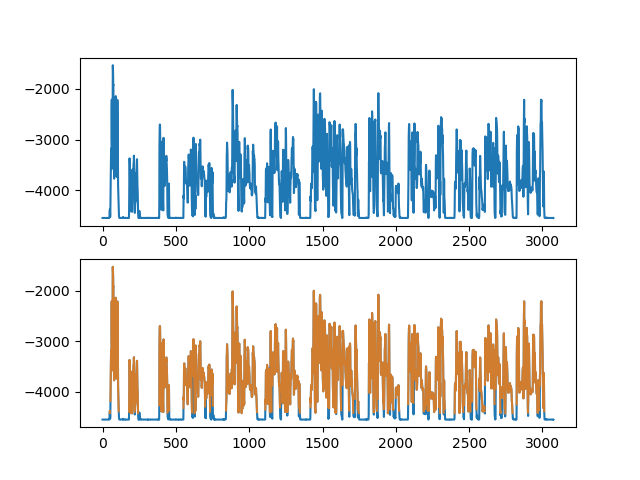

In [13]:
tresh_perc = 0.04 # float in [0,1]
tresh_ = (np.max(loud0)-np.min(loud0))*tresh_perc
tresh = np.min(loud0)+tresh_
filter_tresh_ok = loud0>tresh
plt.figure()
ax1 =plt.subplot(2,1,1)
plt.plot(loud0)
plt.subplot(2,1,2, sharex=ax1)
loudf = np.copy(loud0)
loudf[~filter_tresh_ok] = np.nan
plt.plot(loud0)
plt.plot(loudf, alpha=0.8)

#### now we filter the audio using this regions

In [14]:
ds = 5 #downsampling audio so plots looks nicer and smoother

filter_audio = []
audio_chunks = []
time_chunks = []

for i,filt in enumerate(filter_tresh_ok):
    filter_audio += [filt]*n_points
    
    i_ini = i*n_points
    if i<n_windows-1:
        i_end = (i+1)*n_points
    else:
        i_end = len(audio)
    i_int = np.arange(i_ini,i_end,ds)
    if filt:
        audio_chunks.append(audio[i_int])
    else:
        audio_chunks.append([np.nan]*len(i_int))
    time_chunks.append(time[i_int])    
    
audio_chunks = np.array(audio_chunks)
time_chunks = np.array(time_chunks)

In [15]:
if n_windows*n_points>len(audio):
    n_extra = n_windows*n_points-len(audio)
    print('filter has {} extra elementrs'.format(n_extra))
    filter_audio = filter_audio[:-n_extra]
filter_audio = np.array(filter_audio)    

filter has 30 extra elementrs


In [16]:
len(audio)

196834

In [17]:
audio_filtered = np.copy(audio)
audio_filtered[~filter_audio] = np.nan

<IPython.core.display.Javascript object>


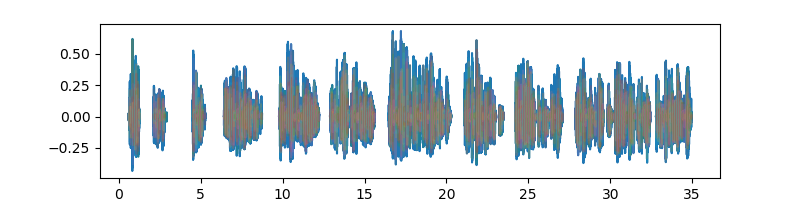

In [18]:
plt.figure(figsize=(8,2))
plt.plot(time, audio_filtered)
for i in range(len(audio_chunks)):
    plt.plot(time_chunks[i], audio_chunks[i], alpha=0.2)

### now we are going to create a nice figure

In [19]:
n_lines = 5

chucnks_per_line = np.ceil(n_windows/n_lines)
max_time = chucnks_per_line*n_points/sr
print('chuncks per lines: {}'.format(chucnks_per_line))
print('max_time: {}'.format(max_time))
max_audio_val = np.nanmax(np.abs(audio_filtered))
audio_rescled = audio_filtered/max_audio_val #now audio goes between (-1,1)

chuncks per lines: 616.0
max_time: 7.152394775036284


In [20]:
np.isnan(audio_chunks[i])

array([ True,  True,  True,  True,  True,  True,  True])

In [21]:
dt = n_points/sr

In [23]:
~np.any(np.isnan(audio_chunks[40]))

False

In [24]:
 not True

False

<IPython.core.display.Javascript object>


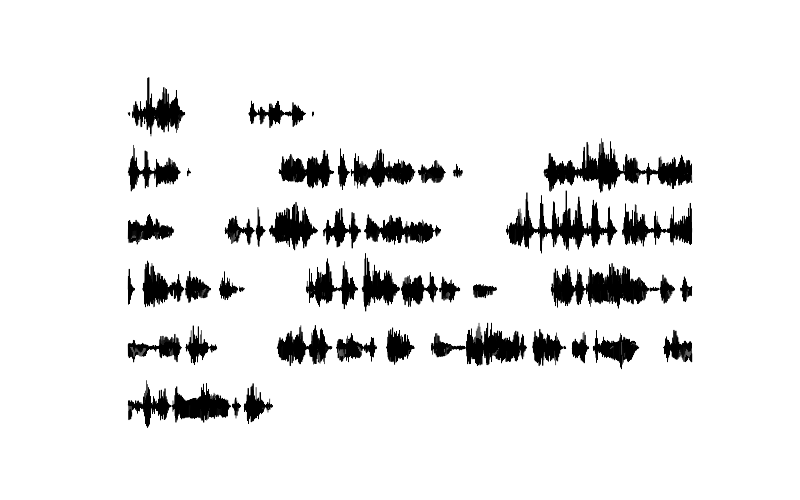

(-0.3581640058055154,
 7.521444121915823,
 -5.663615879416466,
 0.9196180075407028)

In [42]:
#init
n_line = 0
count_per_line = 0
correct_time = 0
has_started = False
ic = 0
last_valid_time = 0
last_time = 0
las_was_valid = False
elements_in_line = False

time_to_break = 1.2

fix_y = 1.0
#go
plt.figure(figsize=(8,5))
for i in range(n_windows):
    
    # existe algun valor no invalido & todavia no se escribio nada en la linea
    if not np.any((np.isnan(audio_chunks[i]))) and not elements_in_line:
        correct_time = time_chunks[i][0]
        elements_in_line = True
        
        
    rel_time = time_chunks[i]-correct_time
    plt.plot(rel_time,np.array(audio_chunks[i])-fix_y*n_line, color='black', lw = 0.5)
    last_time = rel_time[-1]
    
    if not np.any((np.isnan(audio_chunks[i]))):
        last_valid_time = last_time
    
    if (last_time)>max_time and elements_in_line:
        n_line +=1
        elements_in_line = False
    elif last_time-last_valid_time>time_to_break and elements_in_line:
        n_line +=1
        elements_in_line = False        
    
    
    

plt.axis('off')    


<IPython.core.display.Javascript object>


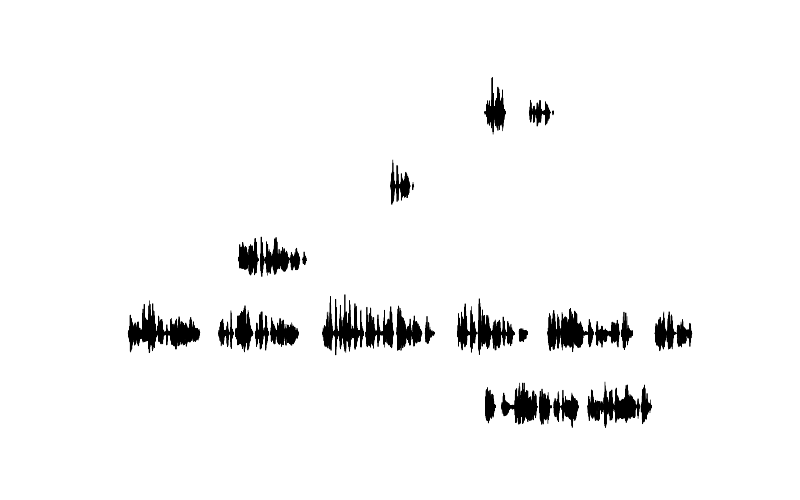

(-13.21796081277213, 8.08515965166909, -5.8736156791448595, 0.9296179980039596)

In [32]:
#init
n_line = 0
count_per_line = 0
correct_time = 0
has_started = False
ic = 0
last_valid_time = 0
last_time = 0
las_was_valid = False

time_to_break = 1.0

fix_y = 1.3
#go
plt.figure(figsize=(8,5))
for i in range(n_windows):

    if not np.any((np.isnan(audio_chunks[i]))):
        has_started=True
        last_valid_time = last_time

    #init time correction
    if not has_started:
        correct_time += dt
#        correct_time = ic*dt        
        ic +=1
    else:
        count_per_line+=1

    if (last_time)>max_time:
        n_line +=1
        count_per_line = 0
        has_started = False

    # condition for full stop
#    if last_time-last_valid_time>time_to_break:
#        n_line +=1
#        
#        correct_time =-last_time
#        has_started = False
#        ic = 0
        
    rel_time = time_chunks[i]-correct_time-(n_line*max_time)            
    plt.plot(rel_time,np.array(audio_chunks[i])-fix_y*n_line, color='black', lw = 0.5)
    
    if audio_chunks[i][-1] == np.nan:
        last_was_valid = False
    else:
        last_was_valid = True
    
    
    
    last_time = rel_time[-1]
plt.axis('off')    


In [24]:
image = np.ones((1200,1200,3))
image.shape


(1200, 1200, 3)

In [25]:
import skimage
from skimage import color

In [26]:
image2 = skimage.util.random_noise(image)
image2 = skimage.util.random_noise(image2, mode='s&p')
image2[:] = image2.mean(axis=-1,keepdims=1) 

<IPython.core.display.Javascript object>


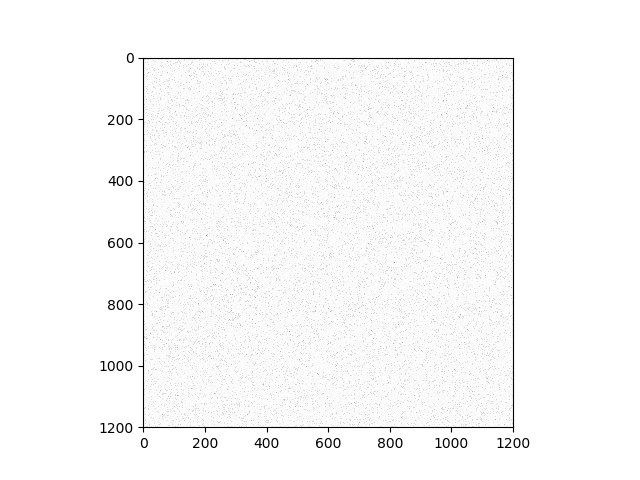

In [27]:
plt.figure()
plt.imshow(image2, alpha=0.4)